In [2]:
!pip install -q transformers

     |████████████████████████████████| 2.5MB 8.7MB/s 
     |████████████████████████████████| 901kB 47.4MB/s 
     |████████████████████████████████| 3.3MB 46.8MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Для бонусного балла - прикручиваю к первой задачке tokenizers
Обучение нового токенизатора через tokenizers насмерть вешает колаб, поэтому я заюзаю предобученный токенайзер из gpt-2

In [5]:
from transformers import GPT2TokenizerFast

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [7]:
def preprocess(text):
    tokens = tokenizer(text)['input_ids']
    return tokens

In [8]:
quora = pd.read_csv('./drive/MyDrive/train.csv.zip')

In [9]:
# переводим тексты в последовательности индексов
X = []

for text in tqdm(quora.question_text):
    tokens = preprocess(text) # no longer need to convert tokens to ids
    X.append(tokens)

100%|██████████| 1306122/1306122 [01:53<00:00, 11480.57it/s]


In [10]:
MAX_LEN = max(len(x) for x in X)
print(f"Max len = {MAX_LEN}")

Max len = 566


In [11]:
mean_len = np.mean([len(x) for x in X])
std_len = np.std([len(x) for x in X])
max_len = round(mean_len + 10*std_len)
print(f"New max len = {max_len} = {mean_len} + 10 * {std_len}")

New max len = 101 = 15.64183743938162 + 10 * 8.55441193539583


In [12]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len, value=tokenizer.eos_token_id)

In [13]:
y = quora.target.values

---
# Model training starts here

---

In [55]:
# enable mixed precision as we are on T4
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
def make_model(style: str = "concat"):
    inputs = tf.keras.layers.Input(shape=(max_len,))
    embeddings = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128)(inputs, )
    if style == "concat":
        mean = tf.keras.layers.Flatten()(embeddings)
    elif style == "avg":
        mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
    elif style == "sum":
        mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings)
    else:
        raise ValueError(f"Unrecognized style argument: {style}")

    dense = tf.keras.layers.Dense(64, activation='relu')(mean)
    dense = tf.keras.layers.Dense(64, activation='relu')(mean)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model


### Task 1: - compare embeddings concatenation/averaging/summation

In [ ]:
model_concat = make_model(style='concat')
model_avg    = make_model(style='avg')
model_sum    = make_model(style='sum')

In [ ]:
model_concat.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 69s 108ms/step - loss: 0.1835 - accuracy: 0.9402 - val_loss: 0.1298 - val_accuracy: 0.9498
Epoch 2/10
606/606 [==============================] - 65s 108ms/step - loss: 0.1208 - accuracy: 0.9522 - val_loss: 0.1157 - val_accuracy: 0.9538
Epoch 3/10
606/606 [==============================] - 65s 108ms/step - loss: 0.1093 - accuracy: 0.9560 - val_loss: 0.1111 - val_accuracy: 0.9553
Epoch 4/10
606/606 [==============================] - 65s 108ms/step - loss: 0.1031 - accuracy: 0.9583 - val_loss: 0.1098 - val_accuracy: 0.9562
Epoch 5/10
606/606 [==============================] - 65s 108ms/step - loss: 0.0983 - accuracy: 0.9602 - val_loss: 0.1100 - val_accuracy: 0.9563
Epoch 6/10
606/606 [==============================] - 65s 108ms/step - loss: 0.0938 - accuracy: 0.9618 - val_loss: 0.1112 - val_accuracy: 0.9559
Epoch 7/10
606/606 [==============================] - 65s 108ms/step - loss: 0.0892 - accuracy: 0.9638 - val_loss: 0.1137 - val_ac

In [ ]:
model_avg.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 65s 106ms/step - loss: 0.3845 - accuracy: 0.9364 - val_loss: 0.2211 - val_accuracy: 0.9396
Epoch 2/10
606/606 [==============================] - 64s 106ms/step - loss: 0.2185 - accuracy: 0.9381 - val_loss: 0.2091 - val_accuracy: 0.9396
Epoch 3/10
606/606 [==============================] - 64s 105ms/step - loss: 0.2071 - accuracy: 0.9381 - val_loss: 0.1942 - val_accuracy: 0.9396
Epoch 4/10
606/606 [==============================] - 65s 107ms/step - loss: 0.1852 - accuracy: 0.9393 - val_loss: 0.1668 - val_accuracy: 0.9429
Epoch 5/10
606/606 [==============================] - 64s 106ms/step - loss: 0.1584 - accuracy: 0.9432 - val_loss: 0.1453 - val_accuracy: 0.9470
Epoch 6/10
606/606 [==============================] - 65s 107ms/step - loss: 0.1423 - accuracy: 0.9466 - val_loss: 0.1349 - val_accuracy: 0.9498
Epoch 7/10
606/606 [==============================] - 65s 107ms/step - loss: 0.1339 - accuracy: 0.9488 - val_loss: 0.1293 - val_ac

In [ ]:
model_sum.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 63s 103ms/step - loss: 0.1581 - accuracy: 0.9443 - val_loss: 0.1245 - val_accuracy: 0.9530
Epoch 2/10
606/606 [==============================] - 62s 102ms/step - loss: 0.1183 - accuracy: 0.9535 - val_loss: 0.1137 - val_accuracy: 0.9552
Epoch 3/10
606/606 [==============================] - 62s 102ms/step - loss: 0.1094 - accuracy: 0.9564 - val_loss: 0.1107 - val_accuracy: 0.9565
Epoch 4/10
606/606 [==============================] - 63s 105ms/step - loss: 0.1045 - accuracy: 0.9580 - val_loss: 0.1098 - val_accuracy: 0.9568
Epoch 5/10
606/606 [==============================] - 62s 103ms/step - loss: 0.1013 - accuracy: 0.9591 - val_loss: 0.1103 - val_accuracy: 0.9567
Epoch 6/10
606/606 [==============================] - 62s 103ms/step - loss: 0.0986 - accuracy: 0.9600 - val_loss: 0.1114 - val_accuracy: 0.9559
Epoch 7/10
606/606 [==============================] - 62s 103ms/step - loss: 0.0964 - accuracy: 0.9609 - val_loss: 0.1108 - val_ac

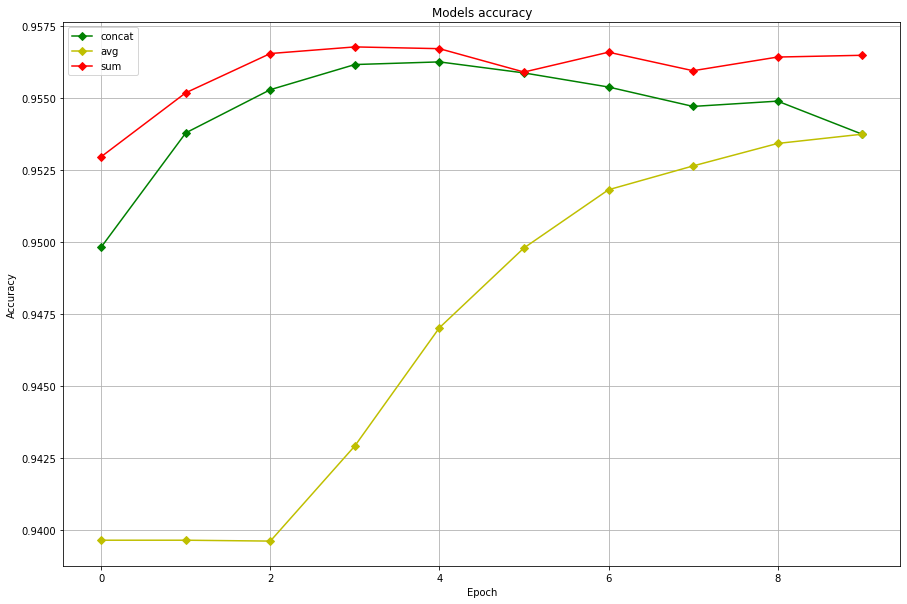

In [ ]:
_ = plt.figure(figsize=(15.0, 10.0))
plt.plot(model_concat.history.history['val_accuracy'], "g-D")
plt.plot(model_avg.history.history['val_accuracy'], "y-D")
plt.plot(model_sum.history.history['val_accuracy'], "r-D")
plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['concat', 'avg', 'sum'], loc='upper left')
plt.show()

In [61]:
from sklearn.metrics import classification_report

In [ ]:
preds_concat = model_concat.predict(X_valid).reshape(-1)
preds_avg = model_avg.predict(X_valid).reshape(-1)
preds_sum = model_sum.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds_concat > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.63      0.55      0.59      3942

    accuracy                           0.95     65307
   macro avg       0.80      0.77      0.78     65307
weighted avg       0.95      0.95      0.95     65307



In [ ]:
print(classification_report(y_valid, (preds_avg > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     61365
           1       0.70      0.41      0.51      3942

    accuracy                           0.95     65307
   macro avg       0.83      0.70      0.75     65307
weighted avg       0.95      0.95      0.95     65307



In [ ]:
print(classification_report(y_valid, (preds_sum > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.69      0.52      0.59      3942

    accuracy                           0.96     65307
   macro avg       0.83      0.75      0.78     65307
weighted avg       0.95      0.96      0.95     65307



---
В общем, sum кажется работает немного лучше concat, и они оба значительно лучше усреднения

---

### Task 2: - Two different embeddings

In [18]:
!pip install -q gensim

In [21]:
from gensim.models import Word2Vec

In [24]:
prepared_training_corpus = []
for text in tqdm(quora.question_text):
    tokenized = tokenizer.tokenize(text)
    prepared_training_corpus.append(tokenized)

100%|██████████| 1306122/1306122 [01:54<00:00, 11414.74it/s]


In [27]:
tokenizer.tokenize("I see queen")

['I', 'Ġsee', 'Ġqueen']

In [35]:
# first embeddings, large window size
w2v_1 = Word2Vec(
    prepared_training_corpus,
    size=128, window=7, workers=-1, min_count=0
)

In [36]:
# second embeddings, small window size
w2v_2 = Word2Vec(
    prepared_training_corpus,
    size=128, window=3, workers=-1, min_count=0
)

In [43]:
w2v_1_matrix = np.zeros((tokenizer.vocab_size, 128))
total_miss_count = 0
for word, idx in tqdm(tokenizer.vocab.items()):
    if word not in w2v_1:
        w2v_1_matrix[idx] = np.zeros(128)
        total_miss_count += 1
    else:
        w2v_1_matrix[idx] = w2v_1.wv[word]

print(f"Unused vocab part is {total_miss_count} words")

  0%|          | 0/50257 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
100%|██████████| 50257/50257 [00:00<00:00, 162604.99it/s]

Unused vocab part is 1982 words


In [44]:
w2v_2_matrix = np.zeros((tokenizer.vocab_size, 128))
total_miss_count = 0
for word, idx in tqdm(tokenizer.vocab.items()):
    if word not in w2v_2:
        w2v_2_matrix[idx] = np.zeros(128)
        total_miss_count += 1
    else:
        w2v_2_matrix[idx] = w2v_2.wv[word]

print(f"Unused vocab part is {total_miss_count} words")

  0%|          | 0/50257 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
100%|██████████| 50257/50257 [00:00<00:00, 139472.02it/s]

Unused vocab part is 1982 words


In [49]:
def make_model_embeddings(matrix_1: np.ndarray, matrix_2: np.ndarray, union_style: str = 'avg'):
    inputs = tf.keras.layers.Input(shape=(max_len,))
    embeddings_1 = tf.keras.layers.Embedding(
        input_dim=tokenizer.vocab_size, output_dim=128, 
        weights=[matrix_1], trainable=False
    )(inputs,)
    embeddings_2 = tf.keras.layers.Embedding(
        input_dim=tokenizer.vocab_size, output_dim=128, 
        weights=[matrix_2], trainable=False
    )(inputs,)

    if union_style == 'avg':
        embeddings = tf.keras.layers.Average()([embeddings_1, embeddings_2])
    elif union_style == 'concat':
        embeddings = tf.keras.layers.Concatenate()([embeddings_1, embeddings_2])
    elif union_style == 'sum':
        embeddings = tf.keras.layers.Add()([embeddings_1, embeddings_2])
    else:
        raise ValueError(f"Unrecognized union_style {union_style}")

    mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings)
    dense = tf.keras.layers.Dense(64, activation='relu')(mean)
    dense = tf.keras.layers.Dense(64, activation='relu')(mean)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

In [50]:
model_concat = make_model_embeddings(w2v_1_matrix, w2v_2_matrix, 'concat')
model_avg    = make_model_embeddings(w2v_1_matrix, w2v_2_matrix, 'avg')
model_sum    = make_model_embeddings(w2v_1_matrix, w2v_2_matrix, 'sum')

In [56]:
model_concat.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 28s 46ms/step - loss: 0.5669 - accuracy: 0.9225 - val_loss: 0.4392 - val_accuracy: 0.9396
Epoch 2/10
606/606 [==============================] - 28s 45ms/step - loss: 0.3546 - accuracy: 0.9381 - val_loss: 0.2902 - val_accuracy: 0.9396
Epoch 3/10
606/606 [==============================] - 28s 46ms/step - loss: 0.2646 - accuracy: 0.9381 - val_loss: 0.2430 - val_accuracy: 0.9396
Epoch 4/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2375 - accuracy: 0.9380 - val_loss: 0.2262 - val_accuracy: 0.9396
Epoch 5/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2230 - accuracy: 0.9380 - val_loss: 0.2120 - val_accuracy: 0.9396
Epoch 6/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2106 - accuracy: 0.9381 - val_loss: 0.2012 - val_accuracy: 0.9399
Epoch 7/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2023 - accuracy: 0.9383 - val_loss: 0.1950 - val_accuracy:

In [57]:
model_avg.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 29s 46ms/step - loss: 0.5766 - accuracy: 0.9268 - val_loss: 0.4510 - val_accuracy: 0.9396
Epoch 2/10
606/606 [==============================] - 27s 45ms/step - loss: 0.3601 - accuracy: 0.9381 - val_loss: 0.2903 - val_accuracy: 0.9396
Epoch 3/10
606/606 [==============================] - 28s 45ms/step - loss: 0.2631 - accuracy: 0.9381 - val_loss: 0.2409 - val_accuracy: 0.9396
Epoch 4/10
606/606 [==============================] - 28s 46ms/step - loss: 0.2368 - accuracy: 0.9381 - val_loss: 0.2273 - val_accuracy: 0.9396
Epoch 5/10
606/606 [==============================] - 28s 45ms/step - loss: 0.2268 - accuracy: 0.9380 - val_loss: 0.2180 - val_accuracy: 0.9396
Epoch 6/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2177 - accuracy: 0.9380 - val_loss: 0.2089 - val_accuracy: 0.9396
Epoch 7/10
606/606 [==============================] - 27s 45ms/step - loss: 0.2096 - accuracy: 0.9381 - val_loss: 0.2018 - val_accuracy:

In [58]:
model_sum.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2048,
    epochs=10
)

Epoch 1/10
606/606 [==============================] - 28s 45ms/step - loss: 0.5392 - accuracy: 0.9337 - val_loss: 0.3927 - val_accuracy: 0.9396
Epoch 2/10
606/606 [==============================] - 28s 46ms/step - loss: 0.3147 - accuracy: 0.9380 - val_loss: 0.2617 - val_accuracy: 0.9396
Epoch 3/10
606/606 [==============================] - 28s 46ms/step - loss: 0.2470 - accuracy: 0.9380 - val_loss: 0.2324 - val_accuracy: 0.9396
Epoch 4/10
606/606 [==============================] - 28s 46ms/step - loss: 0.2301 - accuracy: 0.9380 - val_loss: 0.2201 - val_accuracy: 0.9396
Epoch 5/10
606/606 [==============================] - 28s 45ms/step - loss: 0.2181 - accuracy: 0.9380 - val_loss: 0.2079 - val_accuracy: 0.9396
Epoch 6/10
606/606 [==============================] - 28s 46ms/step - loss: 0.2078 - accuracy: 0.9382 - val_loss: 0.1993 - val_accuracy: 0.9400
Epoch 7/10
606/606 [==============================] - 28s 45ms/step - loss: 0.2011 - accuracy: 0.9382 - val_loss: 0.1942 - val_accuracy:

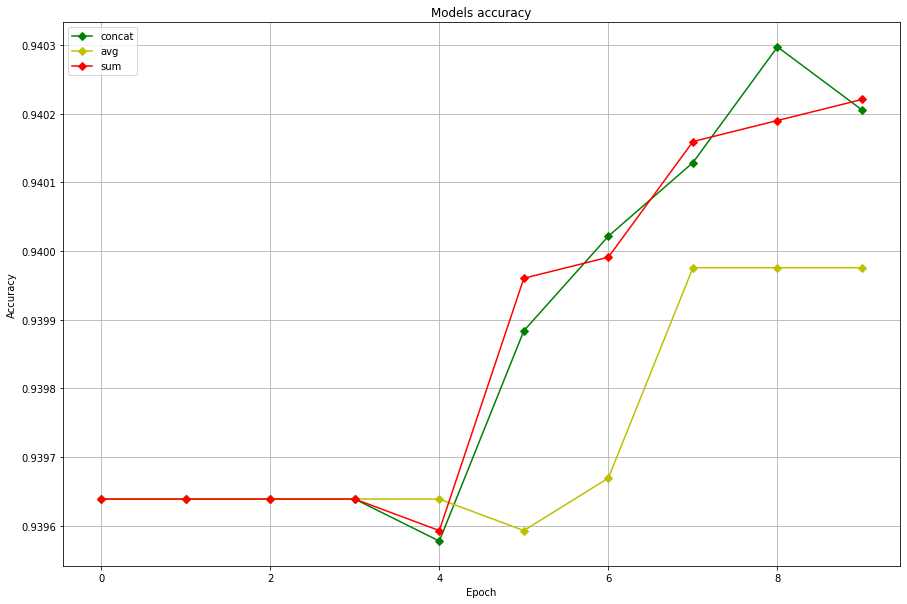

In [59]:
_ = plt.figure(figsize=(15.0, 10.0))
plt.plot(model_concat.history.history['val_accuracy'], "g-D")
plt.plot(model_avg.history.history['val_accuracy'], "y-D")
plt.plot(model_sum.history.history['val_accuracy'], "r-D")
plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['concat', 'avg', 'sum'], loc='upper left')
plt.show()

In [62]:
preds_concat = model_concat.predict(X_valid).reshape(-1)
preds_avg = model_avg.predict(X_valid).reshape(-1)
preds_sum = model_sum.predict(X_valid).reshape(-1)
print("===========  Concat ===========")
print(classification_report(y_valid, (preds_concat > 0.5).astype(int)))
print("=========== Average ===========")
print(classification_report(y_valid, (preds_avg > 0.5).astype(int)))
print("===========   Sum   ===========")
print(classification_report(y_valid, (preds_sum > 0.5).astype(int)))

===========  Concat ===========
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61365
           1       0.54      0.06      0.11      3942

    accuracy                           0.94     65307
   macro avg       0.74      0.53      0.54     65307
weighted avg       0.92      0.94      0.92     65307

=========== Average ===========
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61365
           1       0.54      0.04      0.08      3942

    accuracy                           0.94     65307
   macro avg       0.74      0.52      0.52     65307
weighted avg       0.92      0.94      0.92     65307

===========   Sum   ===========
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61365
           1       0.54      0.06      0.12      3942

    accuracy                           0.94     65307
   macro avg       0.74      0.5

 Наверное значимых различий нет, но принцип такой же как и без предобученных эмбеддингов - sum чуть лучше concat и сильно лучше чем average